# **TAREA 9 - VISIÓN DE MÁQUINA**

**Universidad Nacional de Colombia** <br>
**Maestría en Ingeniería - Automatización industrial**

Juan Sebastián Hernandez Reyes; Julián Felipe Molina Grisales

In [ ]:
#Actualizar la biblioteca de sckit-image
!pip install scikit-image --upgrade

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
#Importar las librerias necesarias 
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.data import vortex
from skimage.transform import warp
from skimage.registration import optical_flow_tvl1, optical_flow_ilk

### 1. Implementar el algoritmo de flujo óptico por el método diferencial.
---

---


In [4]:
dir1 = '/content/drive/MyDrive/Colab Notebooks/Vision_Maquina/Tarea9 - Movimiento en imagenes/frame1.jpg'
dir2 = '/content/drive/MyDrive/Colab Notebooks/Vision_Maquina/Tarea9 - Movimiento en imagenes/frame2.jpg'

image0_color = Image.open(dir1)
image1_color = Image.open(dir2)

image0 = np.array(image0_color.convert("L"))
image1 = np.array(image1_color.convert("L"))

In [5]:
# Se calcula el flujo óptico usando la libreria de skimage
v, u = optical_flow_ilk(image0, image1, radius=15)

# Calcular la magnitud del flujo
norm = np.sqrt(u ** 2 + v ** 2)

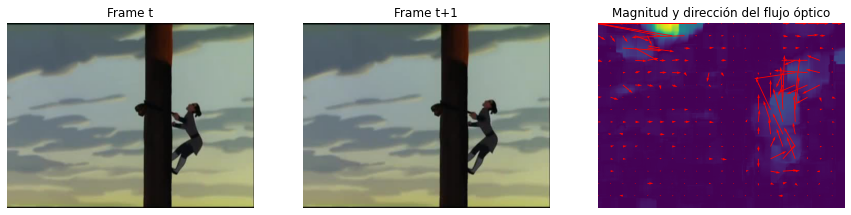

In [6]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 8))

ax0.imshow(image0_color)
ax0.set_title("Frame t")
ax0.set_axis_off()

ax1.imshow(image1_color)
ax1.set_title("Frame t+1")
ax1.set_axis_off()

nvec = 20  # Número de vectores a graficar en cada dimensión
nl, nc = image0.shape
step = max(nl//nvec, nc//nvec)

y, x = np.mgrid[:nl:step, :nc:step]
u_ = u[::step, ::step]
v_ = v[::step, ::step]

ax2.imshow(norm)
ax2.quiver(x, y, u_, v_, color='r', units='dots',
           angles='xy', scale_units='xy', lw=3)
ax2.set_title("Magnitud y dirección del flujo óptico")
ax2.set_axis_off()
plt.show()

### 2. Implementar el filtro de Kalman.
---

---


Para este ejemplo de implementación del filtro de Kalman, se va a hacer un "seguimiento" simple de un objeto viajando en una dimensión, es decir, definiremos un modelo de la posición y velocidad de cualquier objeto y a este aplicaremos el filtro de Kalman. Recordemos las ecuaciones de un sistema discreto primero que todo

$$x_k = A x_{k-1} + B u_{k-1} + w_{k-1}$$
$$y_k = C x_{k}+v_k$$

En el caso de ecuaciones cinématicas, se puede dar la relación entre la posición x y la velocidad $\dot{x}$ de forma discreta como:

*   Posición:
$$x = x_0 + vt + \frac{1}{2} a t^2 \longrightarrow x = x_0 +\dot{x}t + \frac{1}{2} \ddot{x} t^2$$


$$x_k = x_{k-1} + \dot{x}_{k-1}\Delta t + \frac{1}{2}\ddot{x}_{k-1}(\Delta t)^2$$

*   Velocidad:
$$v = v_0 + at \longrightarrow \dot{x} = \dot{x}_0 + \ddot{x} t $$


$$\dot{x}_k = \dot{x}_{k-1} + \ddot{x}_{k-1}\Delta t $$

Poniendolas en un arreglo matricial podemos obtener

$$\underline{x_k} = \begin{bmatrix}x_k \\ \dot{x}_k \end{bmatrix} = \begin{bmatrix}1 & \Delta t \\ 0 & 1 \end{bmatrix} \underline{x_{k-1}} + \begin{bmatrix}0.5 (\Delta t)^2 \\ \Delta t \end{bmatrix} \underline{\ddot{x}_{k-1}}$$

Y ya que solo estamos midiendo la posición, la matriz $C$ se define solo como

$$C = [1\ \ 0]$$

Con esto finalmente tenemos el sistema clásico, pero ya que estamos trabajando bajo la base de un sistema estocástico, faltan definir las definir las varianzas (covarianzas) de los ruidos de medición y proceso, mientras que el ruido de medición es directo siendo

$$R = \sigma_y^2$$

El ruido de proceso tiene que estar en las dimensiones del sistema, por lo que debe ser una matriz, en este caso tenemos una matriz de covarianza de 2 dimensiones la cual se puede expresar como

$$Q = \begin{bmatrix}\sigma_x^2 & \sigma_x\sigma_\dot{x} \\ \sigma_\dot{x}\sigma_x & \sigma_\dot{x}^2 \end{bmatrix}$$

Pero dado a que la "entrada" a nuestro sistema es la aceleración, resulta necesario expresar la desviación estándar de la posición en términos de la desviación estándar de la aceleración, y esto lo conseguimos multiplicando usando la relación $\sigma_x = \frac{1}{2}\Delta t^2 \sigma_a$, debido a que si observamos las ecuaciones, el efecto de la aceleración en el sistema va a estar multiplicado por esta constante, por lo que finalmente obtenemos

$$Q = \begin{bmatrix}0.25 \Delta t^4 & 0.5 \Delta t^3 \\ 0.5 \Delta t^3 & \Delta t^2 \end{bmatrix} \sigma_a^2$$

In [7]:
#Se define la clase la clase del filtro de Kalman, que tenga definidas las 
#funciones para hacer el algoritmo

class KalmanFilter(object):
  def __init__(self, dt, u, std_acc, std_meas):
    
    self.dt = dt #Delta de tiempo de los calculos
    self.u = u
    self.std_acc = std_acc #Desviación estándar de la aceleración

    self.A = np.matrix([[1, self.dt],
                        [0, 1]])
    
    self.B = np.matrix([[(self.dt**2)/2], [self.dt]])

    self.C = np.matrix([[1, 0]])

    self.Q = np.matrix([[(self.dt**4)/4, (self.dt**3)/2],
                        [(self.dt**3)/2, self.dt**2]]) * self.std_acc**2

    self.R = std_meas**2 #std_meas:= Desviación estándar de medición

    #Se inicializa la matriz de covarianza
    self.P = np.eye(self.A.shape[1])
    
    self.x = np.matrix([[0], [0]])

    print(self.Q)


  def predict(self):

    # Actualizar los estados del sistema (a priori)
    self.x = np.dot(self.A, self.x) + np.dot(self.B, self.u)

    # Calcular la covarianza del error de estimación
    # P= A*P_{k-1}*A' + Q
    self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q
    return self.x

  def update(self, z):
    # Por velocidad computacional, se calcula el denominador de la ganancia de 
    #Kalman primero

    # S = C*P_k*C'+R
    S = np.dot(self.C, np.dot(self.P, self.C.T)) + self.R

    # Calcular la ganancia de Kalman
    # K = P_k * C'* inv(H*P*H'+R)
    K = np.dot(np.dot(self.P, self.C.T), np.linalg.inv(S))  

    #Con la ganancia de Kalman, se ajustan los estados del sistema 
    self.x = np.round(self.x + np.dot(K, (z - np.dot(self.C, self.x))))  

    I = np.eye(self.C.shape[1])

    #Y por último se actualiza la covarianza del error de estimación
    # P_k = (I - K_k * C) * P_k
    self.P = (I - (K * self.C)) * self.P  

In [12]:
dt = 0.1
t = np.arange(0, 100, dt) #linspace del tiempo

# Definir la trayectoria real
real_track = 0.1*((t**2)- t)


u= 2             #Aceleración constante
std_acc = 0.25   # Asumamos que la Desv. est. de la aceleración es 0.25 (m/s^2)
std_meas = 1.2   # Y la Desv. est. de medición es 1.2 (m)

# Instanciar el objeto del para el filtro
kf = KalmanFilter(dt, u, std_acc, std_meas)

#Crear las listas para luego plotear los resultados
predictions = []
measurements = []
for x in real_track:
    # Medición
    z = kf.C * x + np.random.normal(0, 50)

    measurements.append(z.item(0))
    predictions.append(kf.predict()[0])
    kf.update(z.item(0))

[[1.5625e-06 3.1250e-05]
 [3.1250e-05 6.2500e-04]]


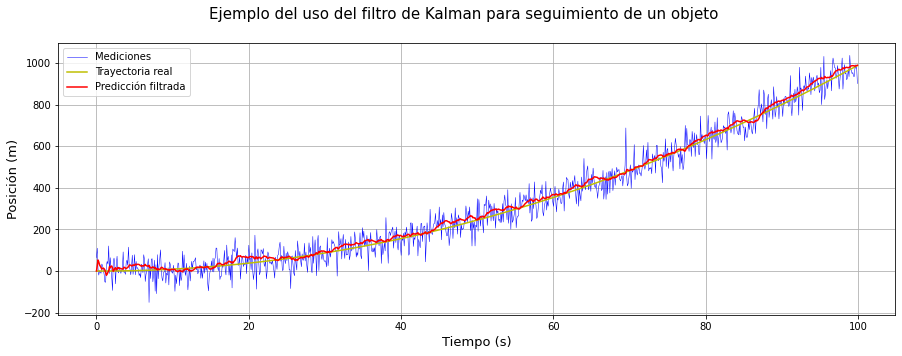

In [13]:
fig = plt.figure(figsize=(15 ,5))
fig.suptitle('Ejemplo del uso del filtro de Kalman para seguimiento de un objeto', fontsize=15)

plt.plot(t, measurements, label='Mediciones', color='b',linewidth=0.5)

plt.plot(t, np.array(real_track), label='Trayectoria real', color='y', linewidth=1.5)
plt.plot(t, np.squeeze(predictions), label='Predicción filtrada', color='r', linewidth=1.5)

plt.xlabel('Tiempo (s)', fontsize=13)
plt.ylabel('Posición (m)', fontsize=13)
plt.legend()
plt.grid()
plt.show()

## Referencias

1.   Notas de clase y presentaciones. Visión de máquina. 2021-I.
2.   Sadli, Rahmad. Object Tracking: 2-D Object Tracking using Kalman Filter in Python. Available [here](https://machinelearningspace.com/2d-object-tracking-using-kalman-filter/)
3.   Registration using optical flow. Scikit-image API. Available [here](https://scikit-image.org/docs/stable/auto_examples/registration/plot_opticalflow.html#sphx-glr-auto-examples-registration-plot-opticalflow-py)
4.  Optical Flow Tutorial. Open Cv. Available [here](https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html)

5.  Sadli, Rahmad. Object Tracking: Simple Implementation of Kalman Filter in Python. Available [here](https://machinelearningspace.com/object-tracking-python/)

6.  Analytics Vidhya. Kalman Filters: A step by step implementation guide in python. Medium. 2019. Available [here](https://medium.com/analytics-vidhya/kalman-filters-a-step-by-step-implementation-guide-in-python-91e7e123b968)
